In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc

from importlib import reload

# locals
import utils as ut
import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.uns['X_umap'] = adata.obsm['X_umap']
adata

AnnData object with n_obs × n_vars = 8574 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags', 'X_umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

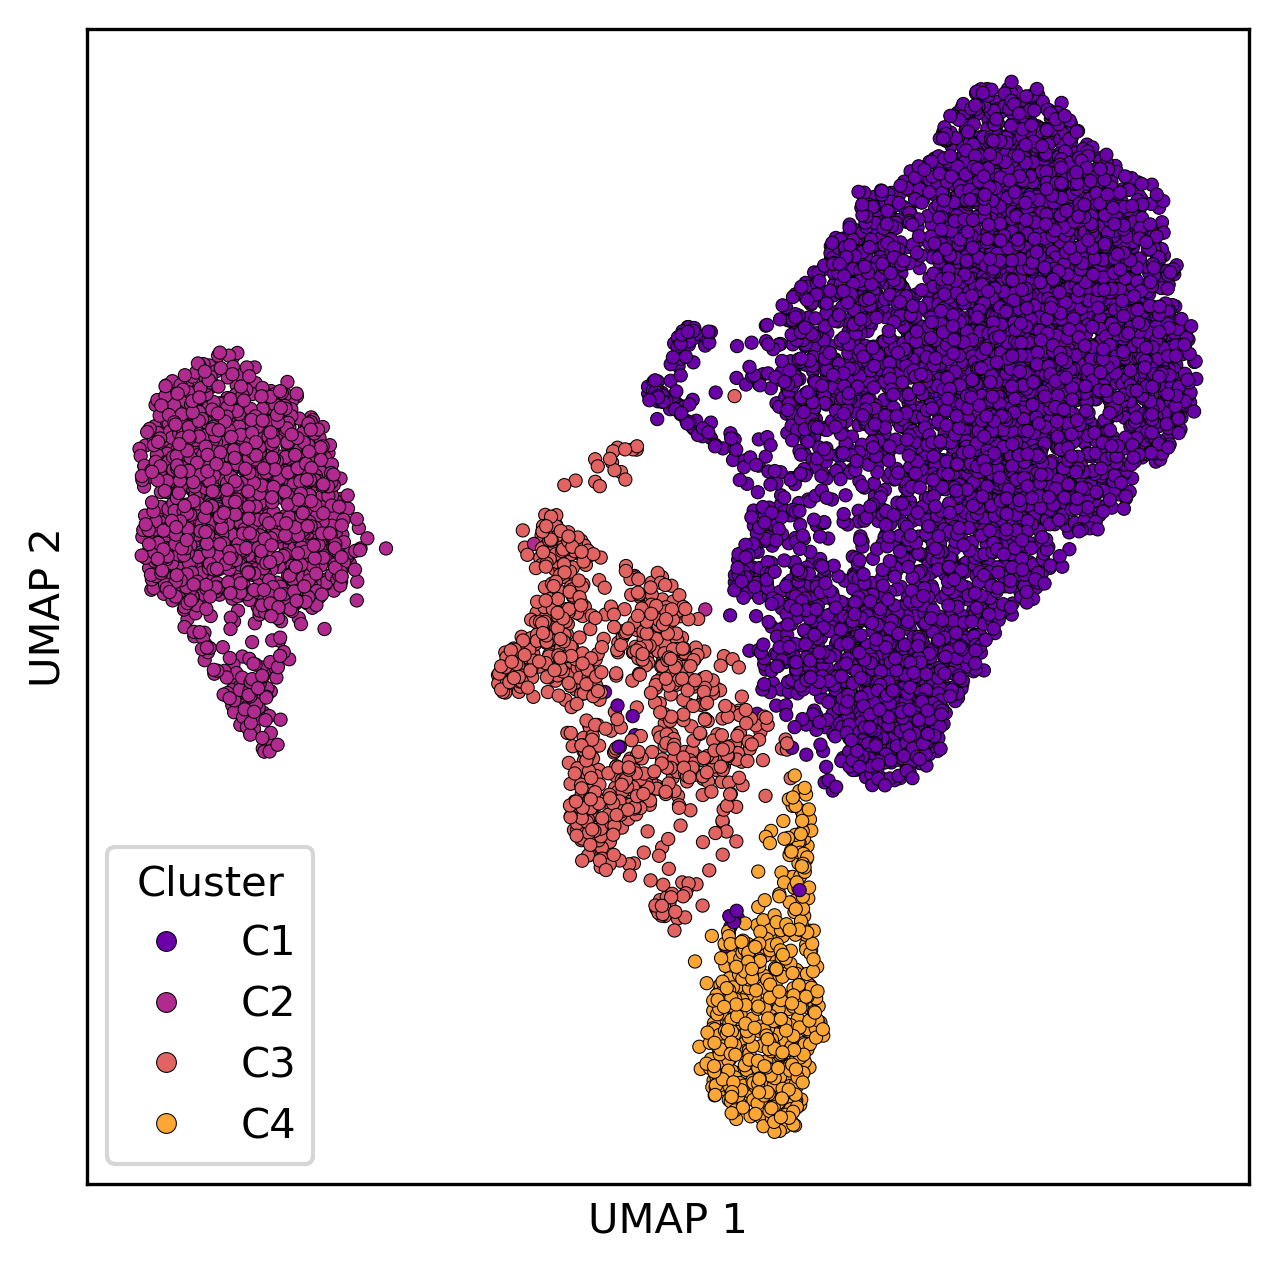

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

min_dist = 0.75
spread = 1.75

sc.tl.umap(adata, 
           min_dist=min_dist, 
           spread=spread)

resolution = "r10"
cluster_labels = adata.uns['clusters'][resolution].apply(lambda x: f"C{int(x)+1}")

sns.scatterplot(data=adata.obs,
                x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                ec='k',
                hue=cluster_labels,
                palette='plasma',
                s=10,)

plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.gca().set_aspect('auto')

sns.move_legend(plt.gca(), 
                title="Cluster",
                loc='best',
                markerscale=1.5)

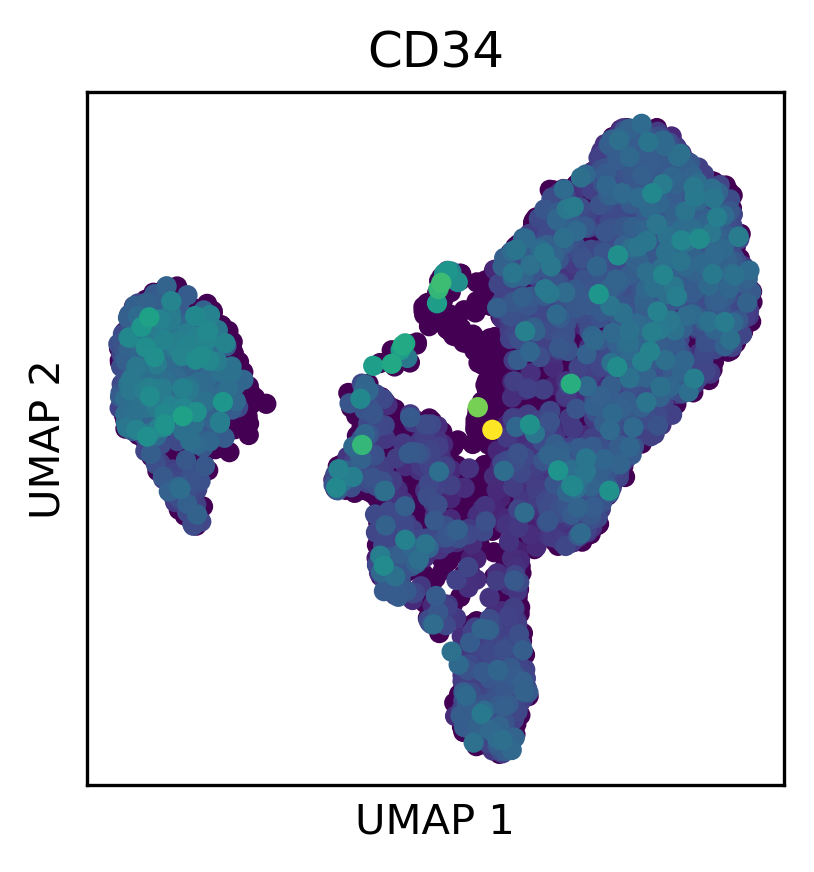

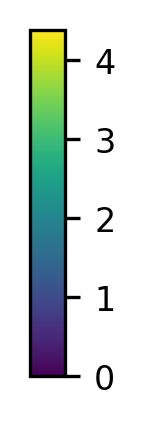

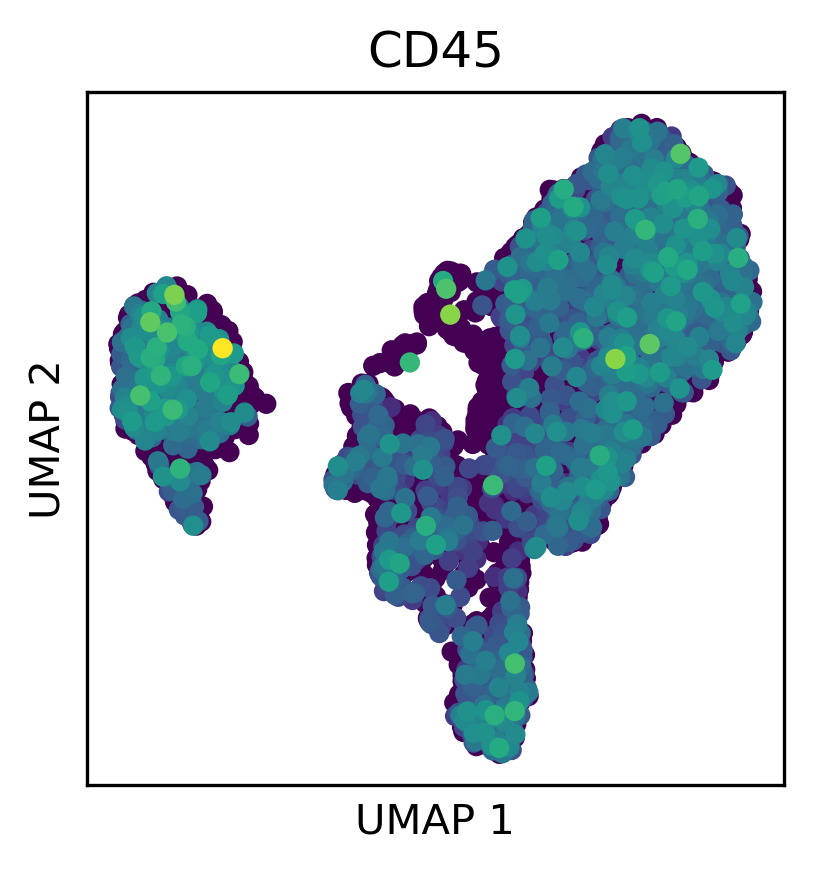

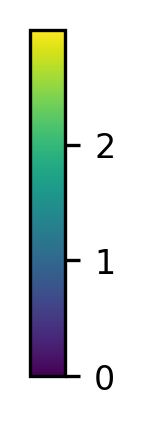

In [4]:
reload(plt2)
adata.var_names = adata.var['gene_name'].values

gene_list = {
    'CD34' : 'CD34',
    'PTPRC' : 'CD45',
}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

for gene_name, gene_label  in gene_list.items():
    plt2.plot_umap_scatter(adata, 
                      s=15, 
                      label=True,
                      title=gene_label,
                      color=gene_name)
    plt.show()
    

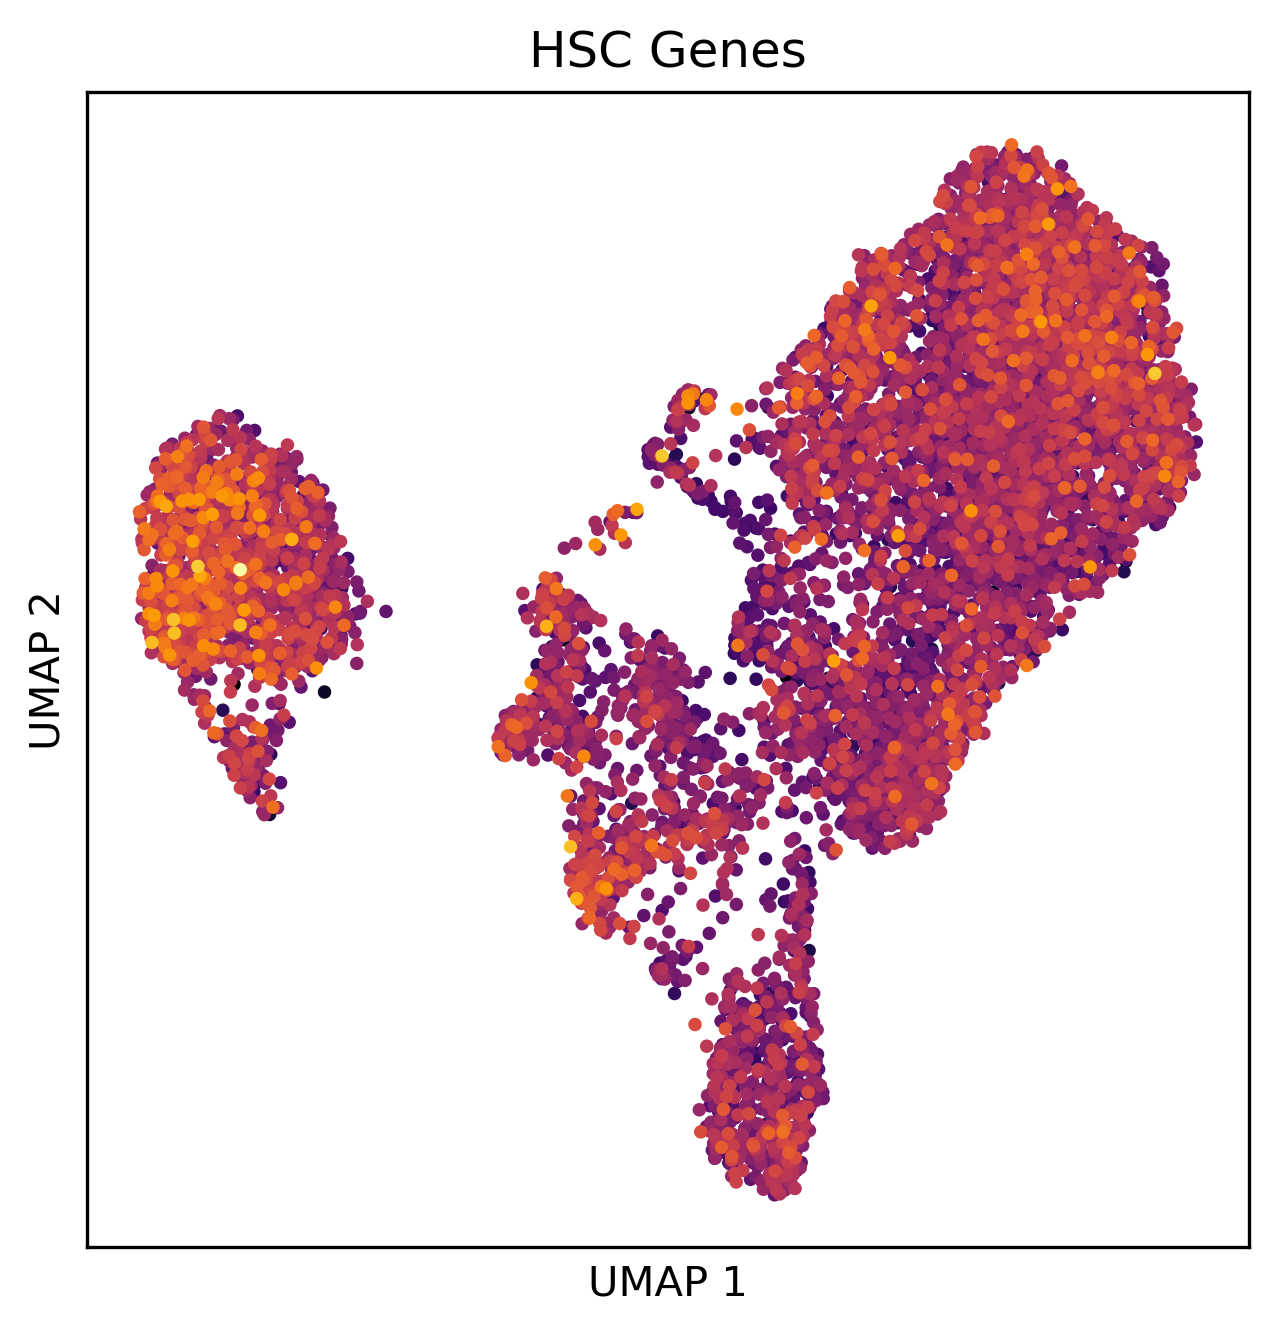

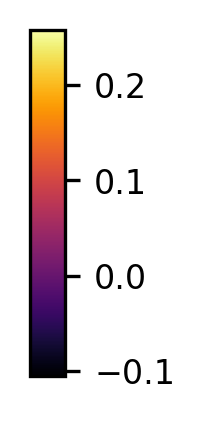

In [5]:
db = 'panglaodb'
column = 'cell_type'
value = 'Hematopoietic stem cells'
genes = adata.uns[db][adata.uns[db][column] == value]['gene_name'].values
gene_ids = adata.var[adata.var['gene_name'].isin(genes)].index

sc.tl.score_genes(adata,
                  gene_list=gene_ids, 
                  ctrl_size=len(gene_ids),
                  score_name=value)

adata.obs[value] = adata.obs[value]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

plt2.plot_umap_scatter(adata, 
                  s=5, 
                  cmap='inferno',
                  title='HSC Genes',
                  color=value)

# plt.title(f"HSC Marker Genes")

Text(0.5, 0, '')

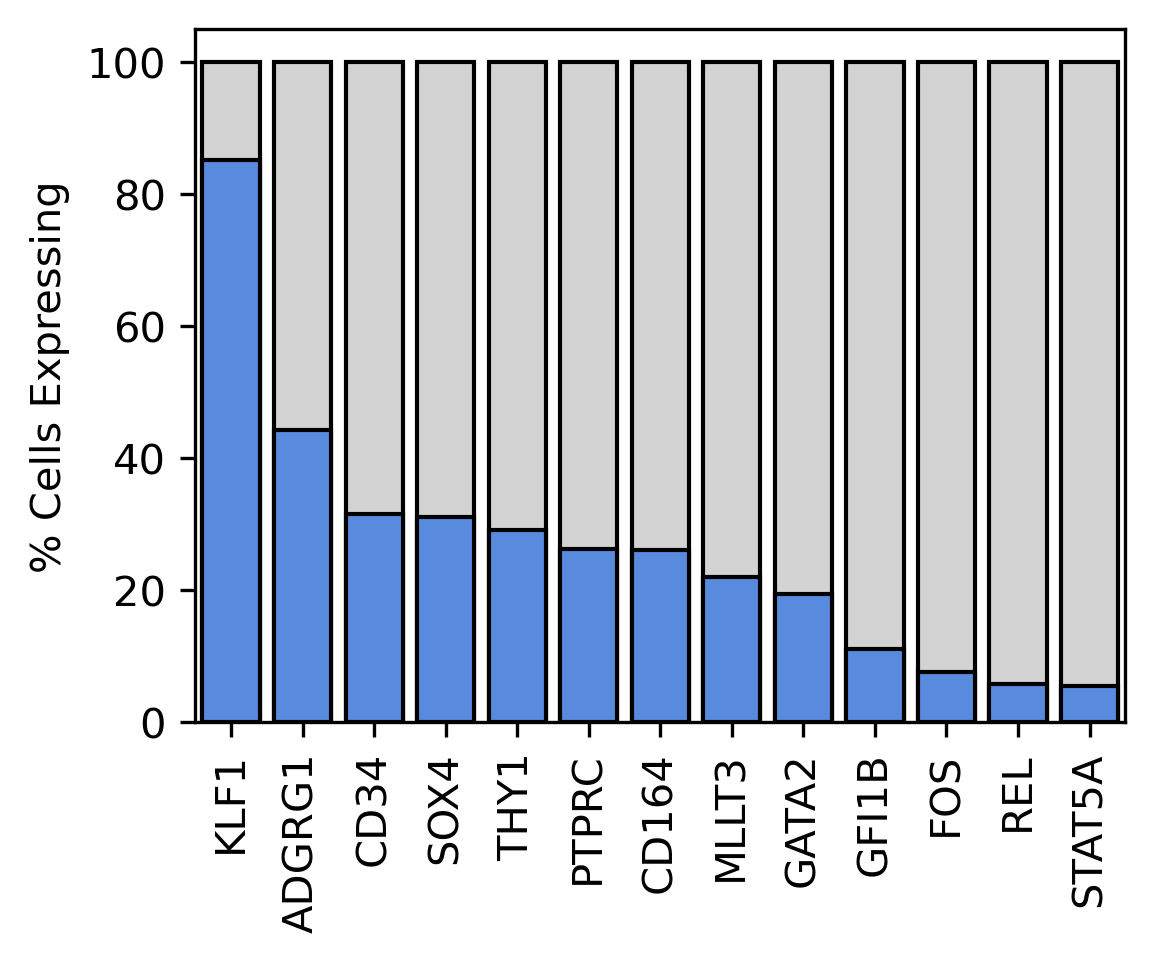

In [7]:

gene_list = [
    'CD34',
    'CD164',
    'THY1',
    'ADGRG1',
    'MLLT3',
    'PTPRC',
    'GATA2', 
    'SOX4',
    'GFI1B', 
    'REL', 
    'STAT5A', 
    'FOS',
    'KLF1',
]

genes = adata.var[adata.var['gene_name'].isin(gene_list)]

data = adata.to_df()
data = data[genes.index]
data.columns = genes['gene_name'].values
res = ut.calculate_gene_expression_stats(data)
res = res.reset_index()
res['backblock'] = 100

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.barplot(data=res, 
            x='index',
            y='backblock',
            color='lightgrey',
            ec='k')

sns.barplot(data=res, 
            x='index',
            y='percent_nonzero',
            color='#4285F4',
            ec='k')


plt.gca().tick_params(axis='x', rotation=90)

plt.ylabel("% Cells Expressing")
plt.xlabel("")

# DEG Analysis

In [ ]:
resolution = "r10"
cluster_labels = adata.uns['clusters'][resolution].apply(lambda x: f"C{int(x)+1}")
adata.obs['cluster_labels'] = cluster_labels

sc.tl.rank_genes_groups(adata, 
                        groupby="cluster_labels",
                        method='wilcoxon',
                        corr_method='benjamini-hochberg',
                        pts=True,
                        key_added='deg',
                       )

deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='deg')

deg.head()

In [ ]:
def top_n_de_genes(df, n=10, alpha=0.05, pct_nz_threshold=0.25, pct_nz_reference=0.90, values='logfoldchanges', gene_list=None):
    """
    Returns the top N differentially expressed genes for each group, ranked by absolute log fold change.

    Args:
        df (pd.DataFrame): DataFrame containing DE analysis results.
        n (int, optional): Number of top genes per group (default: 10).
        alpha (float, optional): Significance level (default: 0.05).
        pct_nz_threshold (float, optional): Min. proportion expressed in group (default: 0.25).
        pct_nz_reference (float, optional): Max. proportion expressed in reference (default: 0.90).
        values (str, optional): Pivot table values to fill (default: 'logfoldchanges')

    Returns:
        pd.DataFrame: A pivot table of log fold changes where rows are groups, columns are names, and values are logfoldchanges
    """

    # Filter by significance and expression percentage
    df_filtered = df.query(
        f"`pvals_adj` <= {alpha} and `pct_nz_group` >= {pct_nz_threshold} and `pct_nz_reference` <= {pct_nz_reference}"
    )
    
    if not gene_list is None:
        df_filtered = df_filtered[df_filtered['names'].isin(gene_list)]

    # Sort by log fold change within each group (descending order for top genes)
    df_sorted = df_filtered.sort_values(
        ['group', 'logfoldchanges'], ascending=[True, False]
    )

    # Group by and select top N rows
    top_genes = df_sorted.groupby('group').head(n)['names'].values

    table = df[df['names'].isin(top_genes)]

    table = pd.pivot_table(
        table,
        index='group',
        columns='names',
        values=values
    )
    
    table = table[top_genes]

    return table


cmap = 'viridis'
n_genes = 5
values = 'logfoldchanges'
pct_nz_threshold = 0.5
pct_nz_reference = 0.90

table = ut,top_n_de_genes(deg, 
                       n=n_genes, 
                       pct_nz_threshold=pct_nz_threshold,
                       pct_nz_reference=pct_nz_reference,
                       values=values)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 5

sns.heatmap(table.T, 
            cmap=cmap, 
            lw=0.1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
cmap = 'viridis'
n_genes = 5
values = 'logfoldchanges'
pct_nz_threshold = 0.25
pct_nz_reference = 0.5

table = top_n_de_genes(deg, 
                       n=n_genes, 
                       pct_nz_threshold=pct_nz_threshold,
                       pct_nz_reference=pct_nz_reference,
                       values=values,
                       gene_list=adata.uns['scenic_transcription_factors']['gene_name'].values)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 5

sns.heatmap(table.T, 
            cmap=cmap, 
            lw=0.1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
adata.uns['scenic_transcription_factors']['gene_name'].values

In [ ]:
pvals_adj = 0.05
logfoldchanges = 1.0

sig = deg.copy()
sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] > logfoldchanges]

print(f"{sig.shape=}")
sig['group'].value_counts()

In [ ]:
sig.columns

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, 
                                n_genes=10,
                                min_logfoldchange=1.0, 
                                figsize=(10,3))